<a href="https://colab.research.google.com/github/lhb00/basic_pytorch_for_deeplearning/blob/main/basic_pytorch_for_deeplearning_theme_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Theme 5. 인공신경망
###1. 다층 퍼셉트론
####(1) 선형 회귀

In [1]:
import torch
import torch.nn as nn 
from matplotlib import pyplot as plt
# 단층 퍼셉트론을 pytorch를 이용해 구축

In [2]:
x = torch.FloatTensor(range(5)).unsqueeze(1) # 2차원 데이터로 표현하기 위하여 unsqueeze(1)로 1차원 확장.
y = 2*x + torch.rand(5,1)

In [3]:
class LinearRegressor(nn.Module): #nn.Module을 상속받는 클래스 
  def __init__(self): # 초기 세팅에 필요한 내용을 입력하는 __init__, super().__init__()을 작성.
    super().__init__()
    self.fc = nn.Linear(1,1,bias=True) # 선형 회귀 모델 y=wx+b를 nn.Linear(N, M, bias=True)로 표현 가능. N: 입력 변수의 개수, M: 출력 변수의 개수, x=N, Y=M임. bias=True가 Default이므로 안 적어도 됨.

  def forward(self,x): #forward 함수는 실제 입력값이 들어와 연산이 진행하는 순서/방법을 정하는 곳. 위의 선형식을 사용하여 x값을 받아 y값을 반환하도록 함.
    y = self.fc(x)

    return y

In [4]:
model = LinearRegressor() #클래스 완성 => 모델 선언
learning_rate = 1e-3
criterion = nn.MSELoss() #MSE를 손실 함수로 사용
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #최적화 방법에 모델 파라미터를 넣어 줄 경우 model.parameters()

In [5]:
# 이전에 나왔던 형태의 코드
loss_stack = []
for epoch in range(1001):

  optimizer.zero_grad()

  y_hat = model(x) # 모델을 이용한
  loss = criterion(y_hat,y) # 예측값 산출과 손실 함수 부분만 달라짐

  loss.backward()
  optimizer.step()
  loss_stack.append(loss.item())

  if epoch%100 ==0:
    print(f'Epoch {epoch}:{loss.item()}')

Epoch 0:30.263439178466797
Epoch 100:2.2134907245635986
Epoch 200:0.31199485063552856
Epoch 300:0.1715921312570572
Epoch 400:0.15109427273273468
Epoch 500:0.13990822434425354
Epoch 600:0.13045307993888855
Epoch 700:0.1220935806632042
Epoch 800:0.11467711627483368
Epoch 900:0.10809576511383057
Epoch 1000:0.1022549644112587


In [6]:
with torch.no_grad(): # 예측!=학습 => with torch.no_grad():을 통해 requires_grad를 비활성화함.
  y_hat = model(x) # 학습된 모델을 통해 예측값 산출

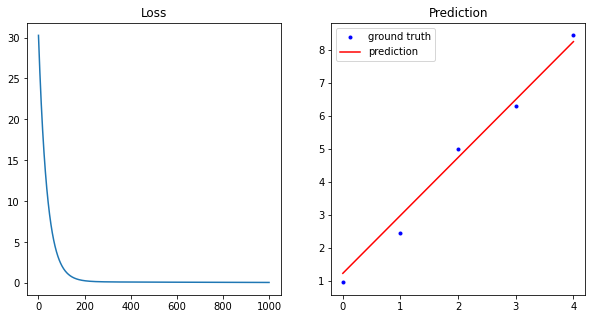

In [7]:
# 역시 이전에도 나왔던 코드. 그래프를 그린다.
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")
plt.subplot(122)
plt.plot(x, y, '.b')
plt.plot(x, y_hat, 'r-') # '-'옵션을 넣어서 5개의 점이 아닌 점이 이어진 선 형식으로 표현
plt.legend(['ground truth', 'prediction'])
plt.title("Prediction")
plt.show()

####(2) 집값 예측하기

In [8]:
# 선형 회귀식은 nn.Linear()가 하나 있는 모델. 선형식은 모든 데이터를 직선으로 예측하기 때문에 학습이 아주 빠르다.
# But, 데이터 내의 변수들은 일반적으로는 비선형 관계, 따라서 nn.Linear()를 줄지어 여러 층으로 깊은 신경망을 생성하는데, 이를 다층 신경망이라한다.
import pandas as pd #pandas. 테이블형 데이터를 다루기에 가장 안성맞춤인 패키지
import numpy as np
from sklearn.model_selection import train_test_split
import torch # torch 내의 다양한 기능들
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error #회귀 문제의 평가를 위하여 RMSE를 사용. MSE에 루트를 씌운 값이고, MSE는 예측 값과 실제 값의 거리의 제곱을 이용하여 정의한다.
# 미분 계산이 간단하여 머신러닝 모델 최적화를 위해 자주 사용되는 손실 함수임. But, 기본 단위에 제곱을 하여 나온 척도 이므로 데이터와 동일한 단위 아님. 그렇기 때문에 루트를 씌워서 평가하는 것!
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('/content/gdrive/My Drive/deeplearning/data/reg.csv', index_col=[0]) #스케일링된 집값 데이터를 read_csv를 통해 불러옴. index_col=[0]를 통하여 첫 번째 열에 있는 데이터의 인덱스를 배제, 데이터프레임 생성.
# 데이터 내 변수의 개수 :13, 인스턴스의 개수 :506

In [20]:
X = df.drop('Price', axis=1).to_numpy() # 데이터프레임 df에서 Price를 제외한 나머지를 변수로 사용. axis=1은 열의 의미 => Price를 열 기준으로 배제
Y = df['Price'].to_numpy().reshape((-1,1)) # Price를 타겟값 Y로 사용

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5) # 50:50으로 학습/평가 데이터를 나눔.

In [22]:
class TensorData(Dataset):

  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self,index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len

trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True) #학습 데이터는 shuffle = True
testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets,batch_size=32, shuffle=False) #평가 데이터는 shuffle = False가 일반적

In [24]:
class Regressor(nn.Module): # 입력층 1개, 은닉층 2개, 출력층 1개를 가진 모델
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13, 50, bias=True) #입력층→은닉층1로 가는 연산 #노드가 13개인 이유 :데이터 피쳐의 개수가 13이므로
    self.fc2 = nn.Linear(50, 30, bias=True) #은닉층1→은닉층2로 가는 연산 #은닉층은 알아서. 여기서는 50, 30개의 노드를 갖도록 구축함(※이전 층의 출력값과 다음 층의 입력값의 크기는 무조건 같아야함.)
    self.fc3 = nn.Linear(30, 1, bias=True) #은닉층2→출럭층으로 가는 연산 #하나의 값으로 표현된 집값을 예측하는 것이므로 출력층은 1개의 노드를 가짐.
    self.dropout = nn.Dropout(0.5) #연산될때마다 50%비율로 랜덤한 노드를 없앰

  def forward(self, x): # 여기서 dropout 함수의 적용 위치를 정해줌
    x = F.relu(self.fc1(x)) #F.relu(self.fc1(x))는 선형 연산 후 ReLU라는 활성화 함수 적용. 일반적으로 활성화 함수는 이전 층에서 다음 층으로 값을 비선형적으로 변환하여 넘겨주는 역할.
    #이는 층과 층 사이의 관계를 비선형으로 만들어 줄 수 있어 성능 향상에 도움됨.
    x = self.dropout(F.relu(self.fc2(x))) #self.dropout(F.relu(self.fc2(x))) 데이터가 노드가 50개인 이전 은닉층에서 30개의 은닉층으로 넘어갈까 ReLu라는 활성화 함수를 거치고, self.dropout을 통해 30개의 50% 확률고 값을 0으로 만듦.
    #dropout은 과적합을 방지하기 위해 노드의 일부를 배제하고 학습하는 방식, 사용위치 지정 가능하나, ※절대로 출력층에 사용해서는 안됨.(당연한 것)
    x = F.relu(self.fc3(x)) #batch size가 32이고 출력값은 하나이므로, 반환값의 크기는 torch.Size([32,1])임. But, 학습 데이터가 203개이므로 32개가 아닌 203의 약수인 29개가 들어온다. 
    return x

In [25]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7) #Adam 최적화 방법을 정의함. weight_decay는 L2 정규화에서의 penalty 값을 의미, 값이 클 수록 제약조건이 강함.

In [29]:
loss_ = [] #그래프를 그리기 위하여 loss 저장용 리스트 생성
n = len(trainloader) #매 에포크 손실 함수값 평균 계산을 위해 배치 반복 수를 n으로 둔다.
for epoch in range(400): # 400번 데이터 반복 학습.
  running_loss = 0.0 # 매 에포크 손실 함수값 평균 계산을 위해 초깃값은 0으로 둔다.
  for data in trainloader: #배치를 불러와 학습.
    inputs, values = data #입력값, 타깃값을 받는다.
    optimizer.zero_grad() #그레디언트 초기화
    outputs = model(inputs) # model에 입력값을 넣어 예측값을 산출
    loss = criterion(outputs, values) # 손실 함수값 계산/최적화 진행
    loss.backward()
    optimizer.step()
    running_loss+=loss.item() # 메 에포크 손실 함수값의 평균을 구하기 위해 runnig_loss에 배치마다 로스를 더함.

  loss_.append(running_loss/n) # 저장용 리스트에 매 에포크 결과 저장.

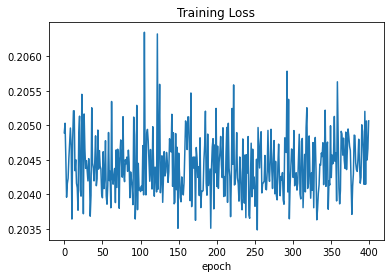

In [30]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [31]:
def evaluation(dataloader): #evaluation 함수에 dataloader를 받음.

  predictions = torch.tensor([], dtype=torch.float) # 예측값과 그에 대응하는 실제값을 저장하기 위해 빈 텐서 생성 
  # 값을 모두 저장 안해도 for문에서 누적 방식으로도 계산 됨. 그러나 여기서는 torch.cat을 사용할거임.
  actual = torch.tensor([], dtype=torch.float)
  with torch.no_grad(): # with torch.no_grad()로 requires_grad 비활성화
    model.eval() # dropout 같은 정규화 기법은 학습시에만 적용해야함. => 모델 내에서 학습 시에만 동작하는 장치들을 비활성화 하기 위해 model.eval()을 적용
    for data in dataloader: # 배치 단위로 데이터를 받아 예측값 산출, 실제값과 누적, 이때 torch.cat에서 0이라는 것은 0번째 차원을 기준으로 누적한다는 뜻
    # 10X2인 두 개의 텐서가 있다고 하자. cat 기준이 0이면, 20X2가 되고, 1이면 10X4가 결과로 나온다.
      inputs, values = data
      outputs = model(inputs)
      predictions = torch.cat((predictions, outputs),0)
      actual = torch.cat((actual, values),0)

  
  predictions = predictions.numpy() # 텐서 데이터를 넘파이 배열로 변경
  actual = actual.numpy()
  rmse = np.sqrt(mean_squared_error(predictions, actual)) # mean_squared_error(predictions, actual)로 MSE를 계산, 루트를 씌워 RMSE를 계산함.

  return rmse

In [33]:
train_rmse = evaluation(trainloader) # 학습 데이터의 RMSE
test_rmse = evaluation(testloader) # 시험 데이터의 RMSE
print("Train RMSE:",train_rmse)
print("Test RMSE:",test_rmse)
# 데이터를 무작위로 나누고, 모델의 초깃값도 random initial parameter를 사용했기 때문에 학습을 할 때마다 결과가 다르게 나올 수 있음.
# 교차 검증/여러 번의 실험을 통해 결과의 경향성을 봐야함.

Train RMSE: 0.45216563
Test RMSE: 0.42723274


###4.경사하강법

####(1) 확률적 경사하강법

In [34]:
# 경사하강법의 특징 : 모든 변수의 미분을 계산해 한 번에 갱신한다는 것. => 노드 수와 가중치 수, 데이터가 많을 경우에는 연산량이 많아 모델의 학습 속도가 느려짐, 계산에 필요한 메모리가 부족한 경우 발생
# 이를 해결하기 위해 데이터를 나눠서 학습하는 방법이 널리 쓰임. ex.n개의 데이터가 있는 경우 k개의 데이터 묶음을 만들어 학습을 진행. 나눠진 데이터 세트를 mini-batch라하며, 이 mini-batch를 이용해 경사하강법을 진행하는 것을 확률적 경사하강법이라함.
# 일반 경사하강법과 확률적 경사하강법(SGD)의 차이는 데이터 전체를 한번에 사용하느냐/나눠서 사용하느냐의 차이만 있을 뿐, 계산과정은 차이가 없다. '확률적'인 이뉴는 mini-batch를 나눌 때 데이터를 무작위로 섞어서 나누기 때문.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

####(2) 다양한 최적화 기법 

#####1. momentum 방법 

In [35]:
# SGD 함수에 momentum 지수를 넣어줌.
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

#####2. Adam 방법

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
# 이 외에도 torch.optim, Adadelta, torch.optim.Adagrad, torch.optim.RMSprop 등이 있다.

####(3) 스케줄링

In [ ]:
# 가변 학습률을 사용하지 않는 방법에 대해서는 학습률은 불변함. 
# 따라서 별도로 학습률이 어떻게 바뀌는지 규칙을 정해주는 것을 스케줄링이라고 함.
"""
optimzer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) # 학습 반복 30번 마다 학습률을 0.1배씩 줄여주고 싶다면, optim.lr_scheduler.StepLR을 optimizer 아래 선언할 수 있음.
<생략>
for epoch in range(400):
  running_loss = 0.0
  for data in trainloader:
    inputs, values = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, values)
    loss.backward()
    optimzer.step()
    # <생략>
    scheduler.step() # for문 안에 scheduler.step()만 추가하면 자동으로 학습률을 변경해줌.
    """
    # 파이토치는 MultiplicativeLR, LambdaLR, StepLR, MultiStepLR, ExponentialLR, CosineAnneal-ingLR 등 다양한 스케줄링 제공

####(4) MADGRAD

In [ ]:
# MADGRAD: 모멘텀 & 가변식 방법을 병행하는 최신 최적화 방법, SGD, ADAM을 능가하는 것. 페북 연구팀이 발표 했었음.
"""
madgrad.MADGRAD(모델 변수 , lr = 학습률(default: 0.01, momentum = 모멘텀지수(default: 0.9), weight_decay=L2페널티(default:0)))
"""

In [39]:
!pip install madgrad #madgrad 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import madgrad #madgrad 불러옴
optimizer = madgrad.MADGRAD(model.parameters()) #기존 최적화 방법의 사용법과 동일하게 모델 변수를 넣어 사용

####(5) 교차 검증

#####1. 교차 검증을 통한 집값 예측 모델 평가

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.model_selection import KFold #KFold는 학습 데이터 세트를 k개의 부분 데이터 세트(폴드)로 나눔 => 그 뒤 k-1개의 폴드는 학습 데이터로 사용, 나머지 1개는 검증 데이터로 사용할 수 있도록 전체 학습 데이터 세트에서 인덱스를 나눠주는 역할.
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv('/content/gdrive/My Drive/deeplearning/data/reg.csv', index_col=[0]) # 마찬가지로 reg.csv를 불러오고 첫번째 열 인덱스 배제
X = df.drop('Price', axis = 1).to_numpy() # 마찬가지로 Price를 열 기준으로 배제
Y = df['Price'].to_numpy().reshape((-1,1)) # 마찬가지로 Price를 타겟값 Y로 사용

In [43]:
class TensorData(Dataset):

  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self,index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.7)
trainset = TensorData(X_train, Y_train) # 교차 검증을 위해 나누기 때문에 미리 DataLoader 정의 X ,
testset = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testset,batch_size = 32, shuffle=False)

In [44]:
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13, 50, bias=True)
    self.fc2 = nn.Linear(50, 30, bias=True)
    self.fc3 = nn.Linear(30, 1, bias=True)

  def forward(self,x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [45]:
kfold = KFold(n_splits=3, shuffle=True) # 학습데이터를 3개의 폴드로 나눠 3겹 교차 검증 진행
criterion = nn.MSELoss()

In [46]:
def evaluaion(dataloader): # 평가하고자 하는 데이터로더를 불러옴

  predictions = torch.tensor([], dtype = torch.float) # 예측값, 실제값을 저장할 빈 텐서 생성
  actual = torch.tensor([], dtype=torch.float)

  with torch.no_grad(): # 평가시에는 모델 파라미터 업데이트 필요 X => requires_grad 비활성화
    model.eval() # 평가를 할 때에는 반드시 .eval() 사용
    for data in dataloader: # 데이터를 불러와 예측 시행 & 예측값과 실제값 저장
      inputs, values = data
      outputs = model(inputs)


      predictions = torch.cat((predictions, outputs),0) #cat을 통해 예측값 누적
      actual = torch.cat((actual, values),0) # cat을 통해 실제값 누적

    predictions = predictions.numpy() # CPU용 텐서를 넘파이 배열로 변환
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions,actual)) # RMSE를 측정하여 성능 평가
    model.train() # 이 예시에서는 상관 없음, but 평가 시 정규화 기술을 배제하여 온전한 모델로 평가 해야함. 따라서 .eval()을 사용. => dropout이나 batch normalization 같이 학습 시에만 사용하는 기술들이 적용 된 모델은 평가 시 비활성화 해야함, 학습 시에는 다시 .train() 사용
    return rmse

In [47]:
validation_loss = [] # 검증 점수를 산출하기 위해 폴드 별 로스 저장 리스트를 만듦
for fold, (train_idx, val_idx) in enumerate(kfold.split(trainset)): # kfold.split(trainset) 이용, 나눠진 학습 데이터의 인덱스를 불러옴

  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx) # TensorData로 정의된 데이터의 일부를 불러와 배치 데이터 형태로 활용할 수 있도록 Data-Loader와 SubsetRandomSampler 함께 사용.
  val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32,
                                            sampler = train_subsampler)
  valloader = torch.utils.data.DataLoader(trainset, batch_size = 32, sampler = val_subsampler)

  model = Regressor() # 매 학습마다 모델 파라미터 초기화 해야함 => for 문 안에 모델 선언
  optimizer = optim. Adam(model.parameters(), lr = 0.001, weight_decay = 1e-7)

  for epoch in range(400): # 데이터 학습
    for data in trainloader:
      inputs, values = data
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, values)
      loss.backward()
      optimizer.step()

  train_rmse = evaluation(trainloader) # 각 검증마다 학습 데이터, 검증 데이터를 가지고 RMSE 계산(여기서는 3번 계산)
  val_rmse = evaluation(valloader)
  print("k-fold", fold, " Train Loss: %.4f, Validation Loss: %.f" %(train_rmse, val_rmse))
  validation_loss.append(val_rmse) # 검증 RMSE 저장

k-fold 0  Train Loss: 0.1198, Validation Loss: 0
k-fold 1  Train Loss: 0.0989, Validation Loss: 0
k-fold 2  Train Loss: 0.1228, Validation Loss: 0


In [48]:
validation_loss = np.array(validation_loss)
mean = np.mean(validation_loss) # 저장된 검증 RMSE의 평균, 표준편차를 구해 출력
std = np.std(validation_loss)
print("Validation Score: %.4f, ± %.4f" %(mean,std))

Validation Score: 0.1313, ± 0.0231


In [50]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle = False) # 학습 데이터 전체에 대해 DataLoader 생성, 학습 데이터에 대한 RMSE 계산
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader) # 평가 데이터 세트에 대해 평가 진행
print("Train RMSE: %.4f" %train_rmse)
print("Test RMSE: %.4f" %test_rmse)

Train RMSE: 0.1206
Test RMSE: 0.1343


####(6) 모델 구조 및 가중치 확인

#####1. 모델 구조

In [51]:
!pip install torchsummary #torchsummary 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary #torchsummary는 구조, 모델 변수를 간략히 알려주는 라이브러리이다.

In [53]:
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13,50) # 변수가 있는 부분, 입력층 => 첫 번째 은닉층에서 가중치는 13x50=650개, 편향이 50개 이므로 총 700개의 변수 존재
    self.fc2 = nn.Linear(50,30) # 첫 번째 => 두 번째 은닉층 사이에는 가중치 50x30 = 1500개, 편향이 30개 이므로 변수가 총 1530개
    self.fc3 = nn.Linear(30,1) # 두 번째 은닉층 => 마지막 출력층 가중치 30개, 편향 1개 총 31개의 변수
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.relu(self.fc3(x))

    return x

In [54]:
model = Regressor()
print(model) # model을 출력하면 __init__ 부분에서 정의된 구조 확인 가능

Regressor(
  (fc1): Linear(in_features=13, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


#####2. 모델 변수

In [55]:
for parameter in model.parameters(): # model.parameters():을 통해 정의된 순서대로 변수를 얻을 수 있음.
  print(parameter.size())

torch.Size([50, 13])
torch.Size([50])
torch.Size([30, 50])
torch.Size([30])
torch.Size([1, 30])
torch.Size([1])


In [56]:
print(model.fc1.weight.size(), model.fc1.bias.size()) #변수명을 알고 있으므로 직접 접근하여 변수를 불러옴.

torch.Size([50, 13]) torch.Size([50])


In [57]:
for name, param in model.named_parameters(): #변수명을 잘 모르는 경우 model.named_parameters()을 통해 변수명, 변수를 동시에 불러올 수 있음.
  print(name, param.size())
# 위의 내용들을 바탕으로 특정 변수에 대한 옵션, 값 변경 가능.

fc1.weight torch.Size([50, 13])
fc1.bias torch.Size([50])
fc2.weight torch.Size([30, 50])
fc2.bias torch.Size([30])
fc3.weight torch.Size([1, 30])
fc3.bias torch.Size([1])


In [58]:
summary(model,(10,13)) #torchsummary에서 제공하는 summary에 model을 넣고 임의의 입력 데이터 사이즈를 넣으면 층마다 출력값의 크기, 변수에 대한 정보를 테이블로 만들어줌.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 50]             700
            Linear-2               [-1, 10, 30]           1,530
           Dropout-3               [-1, 10, 30]               0
            Linear-4                [-1, 10, 1]              31
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
